# Denoise Image with AutoEncoder

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from PIL import Image

2023-05-21 20:49:01.203818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 20:49:02.835604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# set up the path for both training and testing data
data_address = os.path.join(os.getcwd(),'../..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


### Load and Preprocess Images

In [3]:
number_of_figures = 100
output_folder = "../Data/autoencoder_denoised_training_images_sample"
os.makedirs(output_folder, exist_ok=True)

In [4]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Open the image file
    img = Image.open(image_path)
    # Convert the image to grayscale
    img = img.convert('L')
    # Resize the image
    img = img.resize(target_size)
    # Convert the image data to a numpy array and normalize
    img_array = np.array(img) / 255.
    return img_array

In [5]:
# Load and preprocess the images
x_train_normal = np.array([load_and_preprocess_image(path) for path in train_images_normal])
x_train_sick = np.array([load_and_preprocess_image(path) for path in train_images_sick])
x_test_normal = np.array([load_and_preprocess_image(path) for path in test_images_normal])
x_test_sick = np.array([load_and_preprocess_image(path) for path in test_images_sick])

# Concatenate normal and sick images to create full train and test sets
x_train = np.concatenate((x_train_normal, x_train_sick))
x_test = np.concatenate((x_test_normal, x_test_sick))

In [6]:
# Reshape to include channel dimension (1 channel for grayscale images)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

### Train the Autoencoder without artificial noise

In [7]:
input_img = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

2023-05-21 20:50:04.068868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7341 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1
2023-05-21 20:50:04.069407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7349 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:06:00.0, compute capability: 6.1
2023-05-21 20:50:04.069827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 7349 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:09:00.0, compute capability: 6.1
2023-05-21 20:50:04.070172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 7349 MB memory:  -> device: 3, name: NVIDIA GeForce GTX 1080, pc

In [8]:
# Train the autoencoder
autoencoder.fit(x_train, x_train,  # Use the original images as both input and target
                epochs=100,
                batch_size=128,
                shuffle=True)

# Denoise the test images
denoised_images = autoencoder.predict(x_test)


Epoch 1/100


2023-05-21 20:50:06.341218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-21 20:50:06.771297: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-21 20:50:07.796088: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fec539614f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-21 20:50:07.796110: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-05-21 20:50:07.796116: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-05-21 20:50:07.796120: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (2): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-05-21 20:50:07.796123: I tensorflow/compiler/xla/service/service.cc:177]   Str

42/42 [==============================] - 7s 75ms/step - loss: 0.6981
Epoch 2/100
42/42 [==============================] - 3s 65ms/step - loss: 0.6978
Epoch 3/100
42/42 [==============================] - 3s 66ms/step - loss: 0.6975
Epoch 4/100
42/42 [==============================] - 3s 66ms/step - loss: 0.6972
Epoch 5/100
42/42 [==============================] - 3s 66ms/step - loss: 0.6969
Epoch 6/100
42/42 [==============================] - 3s 65ms/step - loss: 0.6966
Epoch 7/100
42/42 [==============================] - 3s 65ms/step - loss: 0.6963
Epoch 8/100
42/42 [==============================] - 3s 66ms/step - loss: 0.6960
Epoch 9/100
42/42 [==============================] - 3s 66ms/step - loss: 0.6957
Epoch 10/100
42/42 [==============================] - 3s 66ms/step - loss: 0.6954
Epoch 11/100
42/42 [==============================] - 3s 65ms/step - loss: 0.6951
Epoch 12/100
42/42 [==============================] - 3s 65ms/step - loss: 0.6949
Epoch 13/100
42/42 [=================

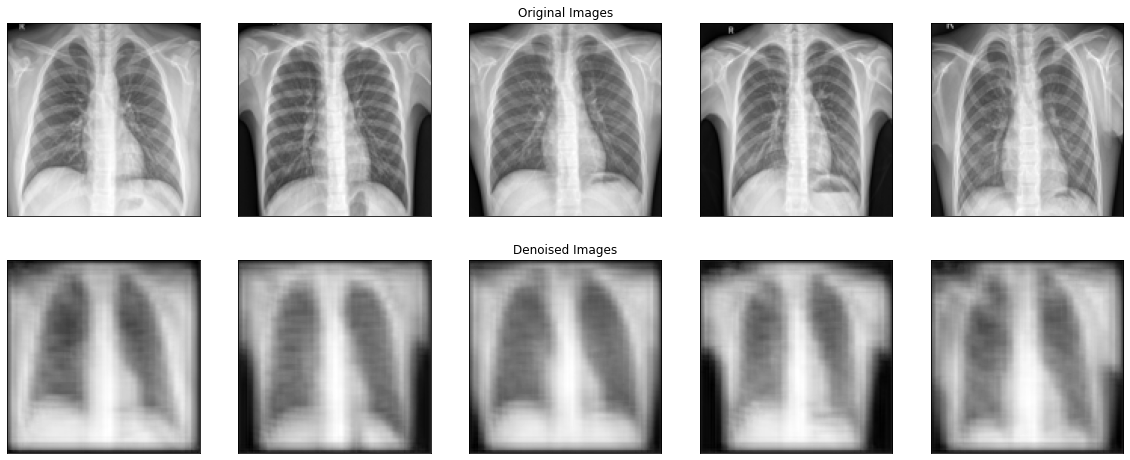

In [9]:
n = 5  # number of images to display
plt.figure(figsize=(20, 8))

for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Original Images')

    # Denoised Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Denoised Images')
        
plt.show()

In [10]:
for i in range(len(denoised_images)):
    img = denoised_images[i].squeeze()  # Remove the channel dimension
    img = img * 255.0  # Convert the images from float to uint8
    img = Image.fromarray(img.astype('uint8'), 'L')  # Convert array to grayscale image
    #img.show()
    #img.save(os.path.join(output_folder, f'denoised_image_{i+1}.png'))

Show average results

In [11]:
# making n X m matrix
def img2np(list_of_filename, size = (500, 500)):
    # iterating through each file
    for i,fn in enumerate(list_of_filename):
        current_image = image.load_img(fn, target_size = size, color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

## Image comparison
def find_mean_img(full_mat, title, size = (500, 500)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

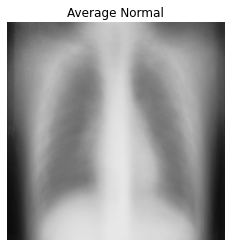

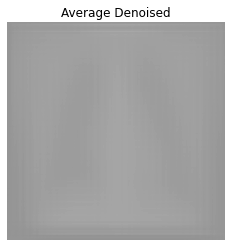

In [12]:
path_draw = test_images_normal[:number_of_figures]
original = img2np(path_draw)
norm_mean = find_mean_img(original, 'Normal')

denoised = img2np([os.path.join(output_folder, f"denoised_image_{i+1}.png") for i in range(number_of_figures)])
denoised_mean = find_mean_img(denoised, 'Denoised')

### Train the Autoencoder with artificial noise

In [13]:
# Add random noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [14]:
input_img = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_noisy = Model(input_img, decoded)
autoencoder_noisy.compile(optimizer='adadelta', loss='binary_crossentropy')

In [15]:
# train the autoencoder
autoencoder_noisy.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True)


Epoch 1/100
42/42 [==============================] - 4s 67ms/step - loss: 0.6916
Epoch 2/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6911
Epoch 3/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6907
Epoch 4/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6902
Epoch 5/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6898
Epoch 6/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6894
Epoch 7/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6890
Epoch 8/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6887
Epoch 9/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6883
Epoch 10/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6879
Epoch 11/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6876
Epoch 12/100
42/42 [==============================] - 3s 67ms/step - loss: 0.6873
Epoch 13/100
42/42 [=====

### Evaluate the denoised images

In [16]:
# Denoise the test images
denoised_images = autoencoder.predict(x_test_noisy)

20/20 [==============================] - 0s 6ms/step


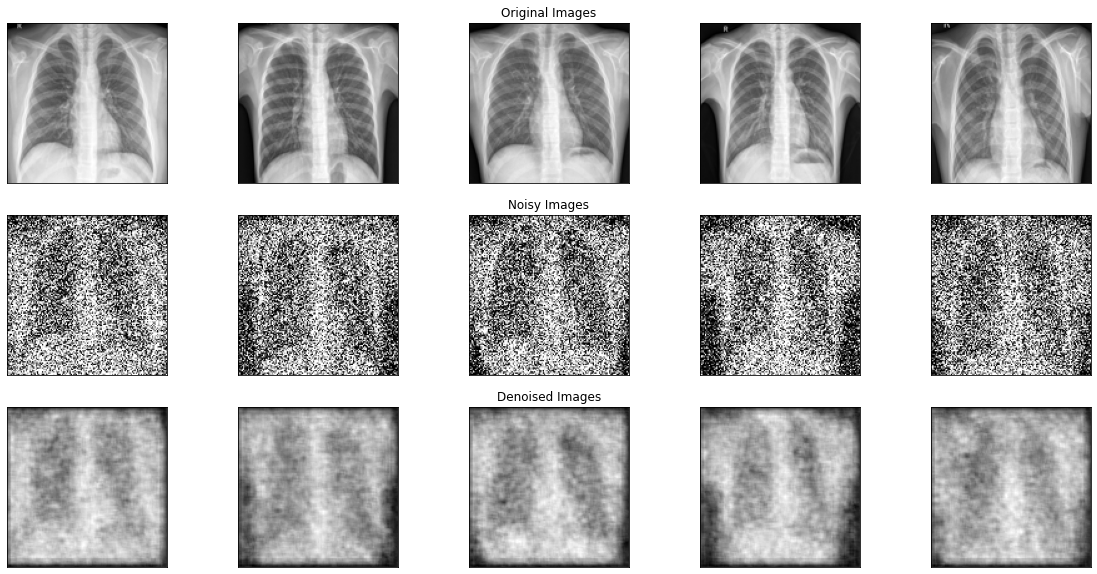

In [17]:
n = 5  # number of images to display

plt.figure(figsize=(20, 10))

for i in range(n):
    # Original Images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Original Images')

    # Noisy Images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Noisy Images')

    # Denoised Images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n//2:
        ax.set_title('Denoised Images')
        
plt.show()
